In [23]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import sys
from functools import partial

from CASutils import averaging_utils as avg
from CASutils import linfit_utils as linfit
from CASutils import plotting_utils as myplot

In [24]:
plotpath="/project/cas/islas/python_plots/singleforcing_paper/figures/supplemental/"

In [25]:
landfrac=xr.open_dataset("/project/cas/islas/cesm2le/fx/LANDFRAC_LENS2.nc")

In [26]:
seas = 'am' ; var=['FLNTC','FSNTC']

In [27]:
# pre-processor to ensure all lon and lat coordinates are the same.  Also adding flexibility for reading in seasonal data
# Taking the ensemble mean
def preprocessor(ds):
    ds['lon'] = landfrac.lon ; ds['lat'] = landfrac.lat
    ds = ds.mean('M')
    ds = ds.sel(year=slice(1920,2050))
    return ds

### Read in CESM1

In [28]:
baselens1 = '/project/cas/islas/python_savs/singleforcing_paper/DATA_SORT/LENS1/'
lens1 = []
for ivar in var:
    dat = xr.open_mfdataset(baselens1+'LENS1_'+ivar+'_'+seas+'.nc', preprocess=partial(preprocessor))
    lens1.append(dat)
lens1 = xr.merge(lens1)

In [29]:
basexaer1 = '/project/cas/islas/python_savs/singleforcing_paper/DATA_SORT/LENS1-SF/'
xaer1 = []
for ivar in var:
    dat = xr.open_mfdataset(basexaer1+'XAER_'+ivar+'_'+seas+'.nc', preprocess=partial(preprocessor))
    xaer1.append(dat)    
xaer1 = xr.merge(xaer1)

In [30]:
baseaer1 = '/project/cas/islas/python_savs/singleforcing_paper/DATA_SORT/CESM1-AAER/'
aer1 = []
for ivar in var:
    dat = xr.open_mfdataset(baseaer1+'AAER_'+ivar+'_'+seas+'.nc', preprocess=partial(preprocessor))
    aer1.append(dat)
aer1 = xr.merge(aer1)

### Read in CESM2

In [31]:
baselens2='/project/cas/islas/python_savs/singleforcing_paper/DATA_SORT/LENS2/'
lens2 = []
for ivar in var:
    dat = xr.open_mfdataset(baselens2+'LENS2_'+ivar+'_'+seas+'.nc', preprocess=partial(preprocessor))
    lens2.append(dat)
lens2 = xr.merge(lens2)

In [32]:
basexaer2="/project/cas/islas/python_savs/singleforcing_paper/DATA_SORT/CESM2-XAAER/"
xaer2 = []
for ivar in var:
    dat = xr.open_mfdataset(basexaer2+'xAER_'+ivar+'_'+seas+'.nc', preprocess=partial(preprocessor))
    xaer2.append(dat)
xaer2 = xr.merge(xaer2)

In [33]:
baseaer2="/project/cas/islas/python_savs/singleforcing_paper/DATA_SORT/LENS2-SF/"
aer2 = []
for ivar in var:
    dat = xr.open_mfdataset(baseaer2+'AAER_'+ivar+'_'+seas+'.nc', preprocess=partial(preprocessor))
    aer2.append(dat)
aer2 = xr.merge(aer2)

### Calculate the global mean

In [34]:
lens1_gm = avg.cosweightlonlat(lens1, 0, 360, -90, 90)
lens2_gm = avg.cosweightlonlat(lens2, 0, 360, -90, 90)
aer1_gm = avg.cosweightlonlat(aer1, 0, 360, -90, 90)
aer2_gm = avg.cosweightlonlat(aer2, 0, 360, -90, 90)
xaer1_gm = avg.cosweightlonlat(xaer1, 0, 360, -90, 90)
xaer2_gm = avg.cosweightlonlat(xaer2, 0, 360, -90, 90)

In [35]:
lens1base = lens1_gm.sel(year=slice(1920,1940)).mean('year')
lens2base = lens2_gm.sel(year=slice(1920,1940)).mean('year')
aer1base = aer1_gm.sel(year=slice(1920,1940)).mean('year')
aer2base = aer2_gm.sel(year=slice(1920,1940)).mean('year')
xaer1base = xaer1_gm.sel(year=slice(1920,1940)).mean('year')
xaer2base = xaer2_gm.sel(year=slice(1920,1940)).mean('year')

In [36]:
lens1anoms = lens1_gm - lens1base
lens2anoms = lens2_gm - lens2base
aer1anoms = aer1_gm - aer1base
aer2anoms = aer2_gm - aer2base
xaer1anoms = xaer1_gm - xaer1base
xaer2anoms = xaer2_gm - xaer2base

In [37]:
aer1xwayanoms = lens1anoms - xaer1anoms
aer2xwayanoms = lens2anoms - xaer2anoms

### Calculate 21 year running mean

In [38]:
# 21 year running means
def calc21ymean(dat):
    datm = dat.rolling(year=21, min_periods=21, center='True').mean('year').dropna('year')
    return datm

In [39]:
aer1anoms_21y = calc21ymean(aer1anoms)
aer2anoms_21y = calc21ymean(aer2anoms)
aer1xwayanoms_21y = calc21ymean(aer1xwayanoms)
aer2xwayanoms_21y = calc21ymean(aer2xwayanoms)

In [40]:
aer1anoms_21y = aer1anoms_21y.load() ; aer2anoms_21y = aer2anoms_21y.load()
aer1xwayanoms_21y = aer1xwayanoms_21y.load() ; aer2xwayanoms_21y = aer2xwayanoms_21y.load() 

In [41]:
cesm1boot = xr.open_dataset("/project/cas/islas/python_savs/singleforcing_paper/DATA_SORT/BOOTSTRAP/figS5/CESM1_bootstrap.nc").load()
cesm2boot = xr.open_dataset("/project/cas/islas/python_savs/singleforcing_paper/DATA_SORT/BOOTSTRAP/figS5/CESM2_bootstrap.nc").load()

In [42]:
def setuppanel(x1, x2, y1, y2,titlestr):
    ax = fig.add_axes([x1, y1, x2-x1, y2-y1])
    ax.set_xlim(1930,2040)
    ax.set_xticks([1940,1960,1980,2000,2020,2040])
    ax.set_xticklabels(['1940','1960','1980','2000','2020','2040'], fontsize=14)
    ax.set_title(titlestr, fontsize=16)
    return ax

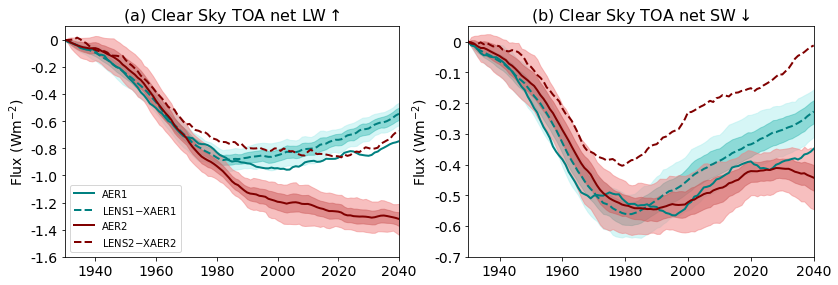

In [43]:
fig = plt.figure(figsize=(16,16))

ax = setuppanel(0.05,0.34,0.8,1,'(a) Clear Sky TOA net LW$\\uparrow$')
ax.set_ylim(-1.6,0.1)
ax.set_yticks([-1.6,-1.4,-1.2,-1,-0.8,-0.6,-0.4,-0.2,0])
ax.set_yticklabels(['-1.6','-1.4','-1.2','-1.0','-0.8','-0.6','-0.4','-0.2','0'], fontsize=14)
ax.set_ylabel('Flux (Wm$^{-2}$)', fontsize=14)

ax.fill_between(cesm1boot.year, cesm1boot.FLNTC_min95_3, cesm1boot.FLNTC_max95_3, color='paleturquoise', alpha=0.5)
ax.fill_between(cesm1boot.year, cesm1boot.FLNTC_min95, cesm1boot.FLNTC_max95, color='lightseagreen', alpha=0.4)
ax.plot(aer1anoms_21y.year, aer1anoms_21y.FLNTC, color='teal', linewidth=2, label='AER1')
ax.plot(aer1xwayanoms_21y.year, aer1xwayanoms_21y.FLNTC, color='teal', linewidth=2, linestyle='dashed', label='LENS1$-$XAER1')

ax.fill_between(cesm2boot.year, cesm2boot.FLNTC_min95_3, cesm2boot.FLNTC_max95_3, color='lightcoral', alpha=0.5)
ax.fill_between(cesm2boot.year, cesm2boot.FLNTC_min95, cesm2boot.FLNTC_max95, color='indianred', alpha=0.5)
ax.plot(aer2anoms_21y.year, aer2anoms_21y.FLNTC, color='maroon', linewidth=2, label='AER2')
ax.plot(aer2xwayanoms_21y.year, aer2xwayanoms_21y.FLNTC, color='maroon', linewidth=2, linestyle='dashed', label='LENS2$-$XAER2')

ax.legend(loc='lower left')


ax = setuppanel(0.4,0.7,0.8,1,'(b) Clear Sky TOA net SW$\\downarrow$')
ax.set_ylim(-0.7,0.05)
ax.set_yticks([-0.7,-0.6,-0.5,-0.4,-0.3,-0.2,-0.1,0])
ax.set_yticklabels(['-0.7','-0.6','-0.5','-0.4','-0.3','-0.2','-0.1','0'], fontsize=14)
ax.set_ylabel('Flux (Wm$^{-2}$)', fontsize=14)

ax.fill_between(cesm1boot.year, cesm1boot.FSNTC_min95_3, cesm1boot.FSNTC_max95_3, color='paleturquoise', alpha=0.5)
ax.fill_between(cesm1boot.year, cesm1boot.FSNTC_min95, cesm1boot.FSNTC_max95, color='lightseagreen', alpha=0.4)
ax.plot(aer1anoms_21y.year, aer1anoms_21y.FSNTC, color='teal', linewidth=2, label='AER1')
ax.plot(aer1xwayanoms_21y.year, aer1xwayanoms_21y.FSNTC, color='teal', linewidth=2, linestyle='dashed', label='LENS1$-$XAER1')

ax.fill_between(cesm2boot.year, cesm2boot.FSNTC_min95_3, cesm2boot.FSNTC_max95_3, color='lightcoral', alpha=0.5)
ax.fill_between(cesm2boot.year, cesm2boot.FSNTC_min95, cesm2boot.FSNTC_max95, color='indianred', alpha=0.5)
ax.plot(aer2anoms_21y.year, aer2anoms_21y.FSNTC, color='maroon', linewidth=2, label='AER2')
ax.plot(aer2xwayanoms_21y.year, aer2xwayanoms_21y.FSNTC, color='maroon', linewidth=2, linestyle='dashed', label='LENS2$-$XAER2')

fig.savefig(plotpath+'figS5.png', bbox_inches='tight', facecolor='white')
fig.savefig(plotpath+'figS5.pdf', bbox_inches='tight', facecolor='white')

In [23]:
print(cesm1boot.FSNTC_max95_3)


<xarray.DataArray 'FSNTC_max95_3' (year: 111)>
array([ 1.13799691e-07,  4.19904736e-03,  1.45290474e-03, -5.40258065e-04,
       -1.88870498e-03, -1.26900507e-03, -2.66604610e-03, -5.02033737e-03,
       -8.62188445e-03, -1.34722273e-02, -1.05040951e-02, -1.11824277e-02,
       -2.22305946e-02, -2.77220794e-02, -3.42326100e-02, -4.85816951e-02,
       -6.07580076e-02, -6.34236403e-02, -7.27332187e-02, -8.62854354e-02,
       -1.00477043e-01, -1.12173157e-01, -1.25527684e-01, -1.35597504e-01,
       -1.52124052e-01, -1.68809624e-01, -1.87475175e-01, -2.11175904e-01,
       -2.33379997e-01, -2.54494427e-01, -2.73716963e-01, -2.96093173e-01,
       -3.14349048e-01, -3.34868021e-01, -3.51526311e-01, -3.70719353e-01,
       -3.82917779e-01, -3.97571494e-01, -4.06050383e-01, -4.14698243e-01,
       -4.26039308e-01, -4.40206920e-01, -4.44279778e-01, -4.55198508e-01,
       -4.63584082e-01, -4.71412545e-01, -4.75935029e-01, -4.78713116e-01,
       -4.83967096e-01, -4.89249635e-01, -4.96488759e